In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using BAT

In [24]:
using Plots

# Low `p` Population: 

In [2]:
conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-1.jld2")

conv_matrices_lc = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
)

images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
event_numbers = [137, 9, 343]

# Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

events_lc = NamedTuple[]

for event_number in event_numbers
    event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    )
    push!(events_lc, event)
end

# High `p` Population: 

In [3]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-1.jld2")

conv_matrices_hc = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2");
event_numbers = [311, 2, 440]

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

events_hc = NamedTuple[]

for event_number in event_numbers
    event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    )
    push!(events_hc, event)
end

In [4]:
events = [events_lc ; events_hc];

# events = events_hc;

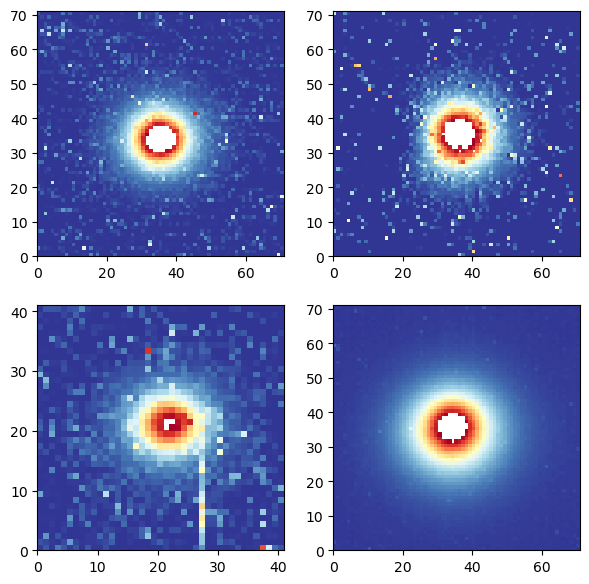

PyObject <matplotlib.collections.QuadMesh object at 0x7f82a73f1fa0>

In [5]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(events[1].cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(events[1].cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(events[1].cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(events[1].cam_4, cmap="RdYlBu_r")

In [6]:
include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

In [7]:
# β = 0.015

β1 = 0.05
β2 = 0.01
β3 = 0.01

prior_cam = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        resx = [truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf)], 
        resy = [truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf)], 
        cam4_resx = truncated(Normal(2, 1), 0, Inf),
        cam4_resy = truncated(Normal(2, 1), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 121.8*β3*sqrt(3)), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
        cam4_psy = truncated(Normal(120.0, 120.0*β3*sqrt(3)), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); # Large Charge

shape_cam = valshape(prior_cam);

In [27]:
# function transforn_nt(ntinit, ind::Integer, nevents::Integer; shapetr=shape_cam) 
#     vect_flat = unshaped(ntinit)
#     return shapetr([vect_flat[1:end-16][ind:nevents:end]; vect_flat[end-15:end]])[1]
# end

likelihood = let 
    evnts = events
    nevents = length(evnts)
    cv_lc = conv_matrices_lc
    cv_hc = conv_matrices_hc
    func = conv_tabl_discrete
    low_charge_ind = 4
    shapetr=shape_cam
    
    params -> begin
       ll = 0.0
        
        for (e_ind, event) in enumerate(evnts) 
            
#             vect_flat = transforn_nt(params, e_ind, nevents)
#             vect_flat = unshaped(params)
            vect_flat = vcat([params...]...)[1:end-4]
            par_tmp = shapetr([vect_flat[1:end-16][e_ind:nevents:end]; vect_flat[end-15:end]])[1]
            @show par_tmp
            if e_ind < low_charge_ind
                ll += likelihood_cam13(par_tmp, event.cam_1, event.population, cv_lc.cam_1, func, 1)
                ll += likelihood_cam13(par_tmp, event.cam_2, event.population, cv_lc.cam_2, func, 2)
                ll += likelihood_cam13(par_tmp, event.cam_3, event.population, cv_lc.cam_3, func, 3)
                ll += likelihood_cam4(par_tmp, event.cam_4, event.population, 4)
            else 
                ll += likelihood_cam13(par_tmp, event.cam_1, event.population, cv_hc.cam_1, func, 1)
                ll += likelihood_cam13(par_tmp, event.cam_2, event.population, cv_hc.cam_2, func, 2)
                ll += likelihood_cam13(par_tmp, event.cam_3, event.population, cv_hc.cam_3, func, 3)
                ll += likelihood_cam4(par_tmp, event.cam_4, event.population, 4)
            end
    
        end
        
        return LogDVal(ll)
    end
end

log_likelihood = likelihood;

In [28]:
# param_truth = (
#         tr_size = [0.2, 0.2],
#         ang_spr = [4.0, 4.0],
#         waist = [2.9,],
#         algmx = [35,35,20,35], 
#         algmy = [35,35,20,35], 
#         cam4_ped = 34.3,
#         cam4_light_fluct = 2.15,
#         cam4_light_amp = event.population*32.16870*10^-2,
#         resx = [0, 0, 0], 
#         resy = [0, 0, 0], 
#         cam4_resx = 0,
#         cam4_resy = 0,
#         psx = [27.1,21.6,114.], 
#         psy = [30.5,23.4,125.],
#         cam4_psx = 90.9, #3*0.0303*10^3,
#         cam4_psy = 89.4, #3*0.0298*10^3,
#         light_amp  = [event.population*35.14744*10^-2, event.population*50.23506*10^-2, event.population*10.09664*10^-2],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

In [29]:
n_events = 3

prior = NamedTupleDist(
    tr_size_x = repeat([truncated(Normal(0.2, 0.04), 0.08, 0.25)], n_events),
    tr_size_y = repeat([truncated(Normal(0.2, 0.04), 0.08, 0.25)], n_events),
    ang_spr_x = repeat([truncated(Normal(4.0, 2.0), 2.0, 6.0)], n_events),
    ang_spr_y = repeat([truncated(Normal(4.0, 2.0), 2.0, 6.0)], n_events),
    waist = repeat([Normal(2.9, 0.03)], n_events),
    algm_1x = repeat([23.0 .. 48], n_events),
    algm_2x = repeat([23.0 .. 48.0], n_events),
    algm_3x = repeat([10.0 .. 30.0], n_events),
    algm_4x = repeat([23.0 .. 48.0], n_events),
    algm_1y = repeat([23.0 .. 48], n_events),
    algm_2y = repeat([23.0 .. 48.0], n_events),
    algm_3y = repeat([10.0 .. 30.0], n_events),
    algm_4y = repeat([23.0 .. 48.0], n_events),
    cam4_ped = repeat([4.0 .. 40.0], n_events) ,
    cam4_light_fluct = repeat([1.0 .. 3.0], n_events),
    cam4_light_amp = repeat([1.6 .. 9.9], n_events), 
    light_amp_1  = repeat([1.0 .. 13.0], n_events), 
    light_amp_2  = repeat([1.0 .. 17.0], n_events), 
    light_amp_3  = repeat([1.0 .. 5.0], n_events), 
    
    resx = [truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf)], 
    resy = [truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(2, 1), 0, Inf)], 
    cam4_resx = truncated(Normal(2, 1), 0, Inf),
    cam4_resy = truncated(Normal(2, 1), 0, Inf),
    psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
    psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
    cam4_psx = truncated(Normal(121.8, 121.8*β3*sqrt(3)), 0., Inf), 
    cam4_psy = truncated(Normal(120.0, 120.0*β3*sqrt(3)), 0., Inf), 
    s_cam = [0.0, 1.478, 15.026, 23.1150],
);


In [30]:
# xx = rand(prior)
# vect_flat = vcat([xx...]...)[1:end-4]

# shaped_dist_nt = valshape(prior)(vect_flat)

# unshaped(shaped_dist_nt)
# log_likelihood(shaped_dist_nt)

In [31]:
v = (tr_size_x = [0.20227241193608322, 0.1801180143489944, 0.24834951746324302], 
    tr_size_y = [0.14894736703771017, 0.1711074585398136, 0.14244672506857275], 
    ang_spr_x = [4.051114736576884, 4.8098954396870015, 5.245396241873286], 
    ang_spr_y = [4.162296130761542, 5.268704168169394, 5.237003467937937], 
    waist = [2.900465430978886, 2.8739801765320787, 2.848453350611521], 
    algm_1x = [47.16741115466944, 30.97384761206392, 31.19791939470802], 
    algm_2x = [34.8047964534087, 23.72232759514793, 30.01562743290467], 
    algm_3x = [25.093506820407228, 20.147031746179653, 26.25540423303729], 
    algm_4x = [32.94368668313423, 39.27238966573856, 25.671296446791366], 
    algm_1y = [29.566722484993438, 27.4188123980774, 47.86317172817509], 
    algm_2y = [45.71995530179399, 34.60565358648816, 33.78876989972116], 
    algm_3y = [12.69591549563199, 18.225890597858164, 10.119710158192401], 
    algm_4y = [47.73044988145864, 43.782167340565316, 33.94499890616786], 
    cam4_ped = [26.74535374001746, 19.11971834574154, 4.621180609271306], 
    cam4_light_fluct = [2.3106377922481047, 2.2631971913926394, 1.0763411720050287], 
    cam4_light_amp = [8.332815309100543, 8.784089575293052, 9.625414617198883], 
    light_amp_1 = [8.269903817066364, 5.702682289969316, 3.852753026280718], 
    light_amp_2 = [11.060573029621299, 10.115427067787962, 5.890769832405422], 
    light_amp_3 = [3.677624147260249, 4.793494276240803, 2.285935220441753], 
    resx = [2.3881377526368994, 2.8078244386696314, 3.0562188706442095], 
    resy = [3.3968166534779978, 2.0333040884449463, 2.9938959538065153], 
    cam4_resx = 1.8495455668455951, cam4_resy = 1.675708161703465, 
    psx = [24.493081656064057, 23.548014377243476, 114.94904411244895], 
    psy = [31.74191604438472, 22.921618207629873, 124.59879569000658], 
    cam4_psx = 120.59664066867958, cam4_psy = 121.63279260553477, 
    s_cam = [0.0, 1.478, 15.026, 23.115])

log_likelihood(v)

par_tmp = (tr_size = [0.20227241193608322, 0.14894736703771017], ang_spr = [4.051114736576884, 4.162296130761542], waist = [2.900465430978886], algmx = [47.16741115466944, 34.8047964534087, 25.093506820407228, 32.94368668313423], algmy = [29.566722484993438, 45.71995530179399, 12.69591549563199, 47.73044988145864], cam4_ped = 26.74535374001746, cam4_light_fluct = 2.3106377922481047, cam4_light_amp = 8.332815309100543, light_amp = [8.269903817066364, 11.060573029621299, 3.677624147260249], resx = [2.3881377526368994, 2.8078244386696314, 3.0562188706442095], resy = [3.3968166534779978, 2.0333040884449463, 2.9938959538065153], cam4_resx = 1.8495455668455951, cam4_resy = 1.675708161703465, psx = [24.493081656064057, 23.548014377243476, 114.94904411244895], psy = [31.74191604438472, 22.921618207629873, 124.59879569000658], cam4_psx = 120.59664066867958, cam4_psy = 121.63279260553477, s_cam = [0.0, 1.478, 15.026, 23.115])
par_tmp = (tr_size = [0.1801180143489944, 0.1711074585398136], ang_spr

LogDVal{Float64}(-1.6601136396058034e6)

In [11]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 100
)

nsamples = 1*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [12]:
# log_likelihood(param_truth)
# @benchmark log_likelihood(param_truth)

In [13]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/s

3772.243644 seconds (5.59 G allocations: 1.257 TiB, 6.77% gc time)


In [14]:
samples = samples_tot.result;

In [ ]:
ev_ind = 1

function shape_event(par) 
    vect_flat = vcat([par...]...)[1:end-4]
    par_tmp = shapetr([vect_flat[1:end-16][e_ind:nevents:end]; vect_flat[end-15:end]])[1]
end

In [15]:
size(flatview(unshaped.(samples.v)))

(73, 84043)

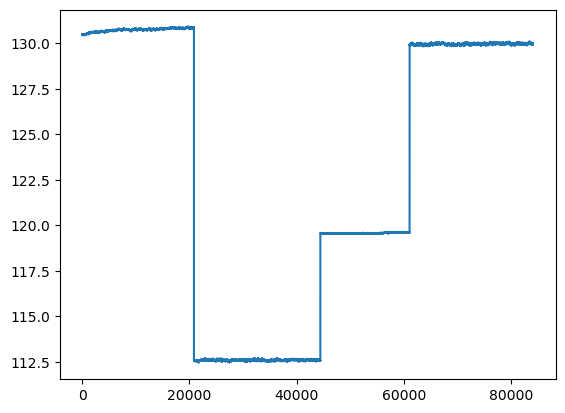

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f814fad8670>

In [33]:
plot(flatview(unshaped.(samples.v))[end,:])

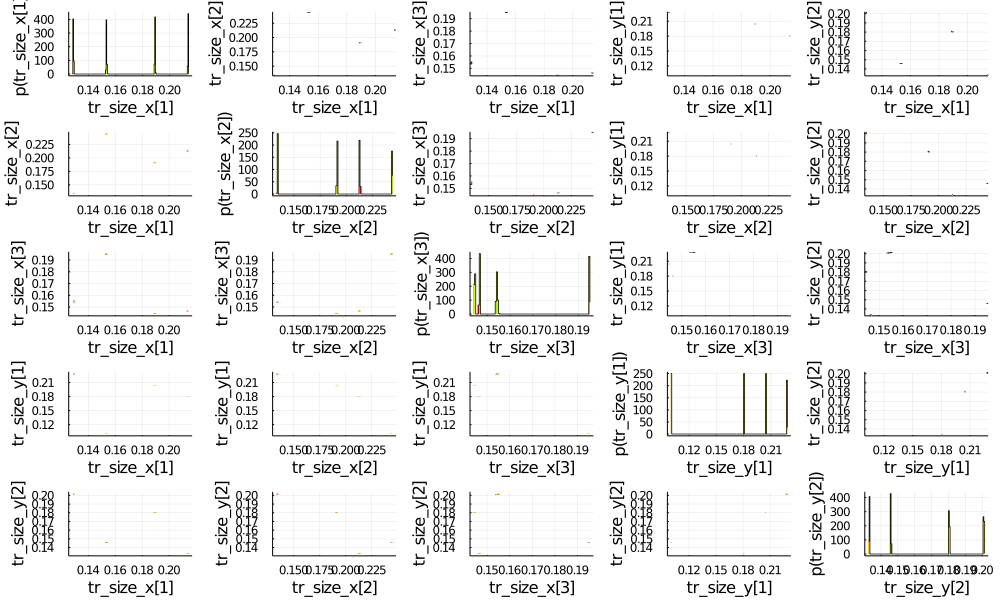

In [25]:
Plots.plot(samples)

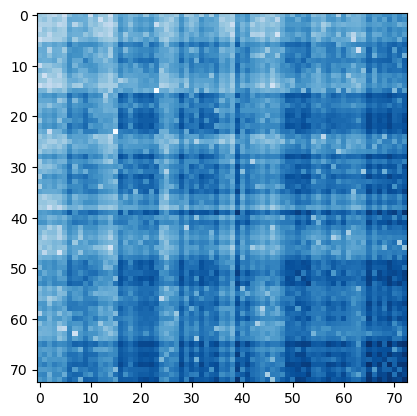

PyObject <matplotlib.image.AxesImage object at 0x7f816caf9550>

In [17]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [18]:
BAT.bat_write("../data/sampling_results/CombineEvents/mcmc-samples-hc.hdf5", unshaped.(samples))

In [19]:
mode(samples)[1]

(tr_size_x = [0.12911282992473827, 0.13412622201051452, 0.15407107088169444], tr_size_y = [0.2278259803351409, 0.2009005016602036, 0.21413071848603132], ang_spr_x = [4.3924322136369165, 5.062566425199252, 5.149928907501694], ang_spr_y = [4.252044759543305, 5.027057172958925, 5.012398419082631], waist = [2.8811185469696983, 2.8116853767357775, 2.890689690108974], algm_1x = [34.51367604048388, 36.92343393756401, 33.73137529464364], algm_2x = [35.402932606498105, 37.63310047849067, 34.44196114755062], algm_3x = [20.87736121129405, 20.558191132188504, 20.44673092836454], algm_4x = [35.05534302273692, 33.993516073300036, 35.42862991767075], algm_1y = [35.66981180722322, 31.710372373600087, 36.074511517000325], algm_2y = [37.35742000712075, 31.875894476788087, 36.97534383325855], algm_3y = [22.204648388789487, 21.22477574530179, 21.948750819533316], algm_4y = [34.52415394551558, 35.281208824351495, 34.97158894488609], cam4_ped = [28.948532055490556, 30.204071354400874, 27.256814703567972], c

In [20]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size_x = [0.21375, 0.1345, 0.14675], tr_size_y = [0.1805, 0.14575, 0.24575], ang_spr_x = [3.955, 4.5024999999999995, 4.9175], ang_spr_y = [5.3149999999999995, 5.0275, 4.3774999999999995], waist = [3.0045, 2.8785, 2.87675], algm_1x = [34.2975, 36.925, 33.61], algm_2x = [35.235, 37.629999999999995, 39.725], algm_3x = [17.950000000000003, 19.725, 17.83], algm_4x = [34.771, 33.983000000000004, 35.431], algm_1y = [35.8725, 31.725, 36.0975], algm_2y = [34.325, 31.645, 36.975], algm_3y = [20.810000000000002, 22.549999999999997, 22.025], algm_4y = [34.8975, 35.4725, 34.885000000000005], cam4_ped = [15.850000000000001, 29.695, 32.225], cam4_light_fluct = [2.9575, 2.1075, 2.367], cam4_light_amp = [7.2925, 8.503, 8.731], light_amp_1 = [6.235, 8.275, 8.775], light_amp_2 = [1.025, 1.025, 1.025], light_amp_3 = [1.005, 1.005, 1.005], resx = [0.025, 4.609999999999999, 0.005], resy = [0.025, 2.865, 2.1950000000000003], cam4_resx = 5.445, cam4_resy = 3.8099999999999996, psx = [31.85, 27.3

In [21]:
mean(samples)[1]

(tr_size_x = [0.1712397367965558, 0.1955163197612716, 0.16008569512592202], tr_size_y = [0.1782545637956654, 0.16512933050662806, 0.20532306492212407], ang_spr_x = [4.188281130243231, 4.57638346932079, 4.783568298826762], ang_spr_y = [4.398380859393455, 4.962526886512453, 4.746671191835796], waist = [2.9156735043295647, 2.876448260535629, 2.905265991087986], algm_1x = [34.30535665795393, 35.5998483875388, 33.45760259466074], algm_2x = [35.341881903468476, 36.89292601461945, 36.06986744552453], algm_3x = [19.339043609619516, 18.66204989868973, 19.570351931156793], algm_4x = [34.915176194453295, 33.93764703554283, 35.471978978650625], algm_1y = [35.57720014157669, 33.66750306481003, 36.33298745676778], algm_2y = [36.68776033116224, 32.05916523925688, 39.41578775790373], algm_3y = [22.332511107642922, 22.19562759319256, 20.39847550277412], algm_4y = [34.61418362335332, 35.45725146095085, 34.93796881276149], cam4_ped = [26.653119860479222, 29.430333951472193, 30.535097122389768], cam4_ligh

In [22]:
std(samples)[1]

(tr_size_x = [0.0325587506082506, 0.040023865649449236, 0.02044476028800472], tr_size_y = [0.04796620860055245, 0.026993380690570674, 0.039286757329594676], ang_spr_x = [0.6067044701723076, 0.2893120327800717, 0.2648027890664531], ang_spr_y = [0.6080221804164657, 0.2564137830674871, 0.23294963453268888], waist = [0.055521962618180556, 0.042908528012450646, 0.022446610842244495], algm_1x = [0.15002739898502296, 2.3885090390261676, 0.8581280229935098], algm_2x = [0.4687946415874369, 0.9915890908514369, 2.21516218916934], algm_3x = [1.6957849958467675, 2.663989709858442, 1.1419014227605802], algm_4x = [0.09966366283926702, 0.07213333850268902, 0.11530525552850561], algm_1y = [0.21191707944145585, 3.2828848871899, 0.32001616072344125], algm_2y = [1.5450669584082648, 0.5697387804400212, 2.7077649729204096], algm_3y = [1.1310253216195696, 0.9843082287715559, 2.1524626595691974], algm_4y = [0.17075478301876662, 0.31860424687259054, 0.045341002575631194], cam4_ped = [6.331600611847201, 0.64344

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
params_array = [param_truth, mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [ ]:
β = 0.015

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
#         δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         is_ped = [29 .. 35],
#         is_light_f = [1.9 .. 2.3,],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


In [ ]:
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        is_ped = [29 .. 35],
        is_light_f = [1.9 .. 2.3,],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 50..150,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 120
);

algorithm = MetropolisHastings();

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
mode(samples)[1]
 
#2.11452269382

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17,18,19,20,21]
names = dims
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22,23,]
names = dims
# levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# Experiment Event: 

images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)


In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_cam_integral([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [35,35,20,35], 
        μ_y = [35,35,20,35], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# 30 iterationsfro convergence 

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# #40 iterations for convergence 

In [ ]:
β_min = 0.6
β_max = 1.4

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
    
        int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
                β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
                β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
                β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );

# 43 chains for convergence 

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..208,
#     max_nsamples_init = 600,
#     max_nsteps_init = 600,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 1700,
#     max_nsteps_per_cycle = 1700,
#     max_time_per_cycle = Inf,
#     max_ncycles = 60
# );

# nsamples = 6*10^4
# nchains = 4;

In [ ]:
# resolution + prior AWAKE 

β_min = 0.7
β_max = 1.3

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(3.07, 0.5), 0, 5), truncated(Normal(3.95, 0.5), 0, 5), truncated(Normal(2.13, 0.5), 0, 5), truncated(Normal(2.16, 0.5), 0, 5)], 
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [3.07, 3.95, 2.13, 2.16],
        σ_y = [3.07 , 3.95, 2.13, 2.16], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [0, 0, 0, 0],
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


# #40 iterations for convergence 
# res 1: mean([0.0874, 0.0895] ./ [0.0270999, 0.03049999999999997])
#res2: [0.021599999999999397, 0.023400000000000087] ./ [0.0861, 0.0918]
# res 3: mean([0.303, 0.201] ./ [0.11400000000000077, 0.125])
# res4: mean([0.202, 0.189] ./ [0.030303030303030304, 0.02981267596704524] ) / 3

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [Normal(35147.44, β*35147.44), Normal(50235.06, β*50235.06), Normal(10096.64, β*10096.64), Normal(33406.9, β*33406.9)],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );



In [ ]:
# β_min = 0.9
# β_max = 1.1

# prior = NamedTupleDist(
#         tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
#         ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
#         s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
#         μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
#                 β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
#                 β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
#                 β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
#         μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
#                 β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
#                 β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
#                 β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
#         σ_x = [0,0,0,0], 
#         σ_y = [0,0,0,0], 
#         δ_x = [ β_min*param_truth.δ_x[1]..β_max*param_truth.δ_x[1],
#                 β_min*param_truth.δ_x[2]..β_max*param_truth.δ_x[2],
#                 β_min*param_truth.δ_x[3]..β_max*param_truth.δ_x[3],
#                 β_min*param_truth.δ_x[4]..β_max*param_truth.δ_x[4]],
    
#         δ_y = [ β_min*param_truth.δ_y[1]..β_max*param_truth.δ_y[1],
#                 β_min*param_truth.δ_y[2]..β_max*param_truth.δ_y[2],
#                 β_min*param_truth.δ_y[3]..β_max*param_truth.δ_y[3],
#                 β_min*param_truth.δ_y[4]..β_max*param_truth.δ_y[4]],
    
#         int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
#                 β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
#                 β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
#                 β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..200,
#     max_nsamples_init = 2000,
#     max_nsteps_init = 2000,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 5000,
#     max_nsteps_per_cycle = 5000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 45
# );

# algorithm = MetropolisHastings()


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior);

In [ ]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 120..220,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 200
);

algorithm = MetropolisHastings()

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
# BAT.bat_write("test.hdf5", unshaped.(samples))
# CSV.write(SAVE_PATH*file_name_*".csv", output_sp_ms.info)

In [ ]:
# samples = bat_read("../data/sampling_results/Resolution_Effects/wc_resolution.hdf5") 
# samples = varshape(prior).(samples)
# # wcr_samples_uw = bat_sample(wcr_samples, length(wcr_samples)).result;

In [ ]:
# int = bat_integrate(samples)

In [ ]:
mode(samples)[1]

In [ ]:
bat_integrate(samples)

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/wr_px_resolution.hdf5", unshaped.(samples))

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17, 18, 19, 20, 21]
names = ["14", "15", "16", "17", "18", "19", "20", "21"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22, 23, 24, 25, 26, 27, 28, 29]
names = [22, 23, 24, 25, 26, 27, 28, 29]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result ./ length(samples)

In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
@show round.(unshaped(std(samples)), sigdigits=3)

In [ ]:
unshaped(std(samples))

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/w-34d-tmp_resolution.hdf5", unshaped.(samples))

# Whitenig: 

In [ ]:
using MultivariateStats

In [ ]:
resamples = bat_sample(samples, length(samples)).result
flat_samples = collect(flatview(unshaped.(resamples.v)))

W = fit(Whitening, flat_samples)

plt.scatter(flat_samples[1,:], flat_samples[2,:])


In [ ]:
smpl_tr = W.W' * (flat_samples .- W.mean) # white samples
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])


In [ ]:
# min_s = minimum(smpl_tr, dims=2)
# max_s = maximum(smpl_tr, dims=2)

# @show min_s, max_s;

In [ ]:
smpl_tr = inv(W.W')*smpl_tr .+ W.mean # back to original space
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])

In [ ]:
β_min = 0.8
β_max = 1.2

minv = [β_min*param_truth.tr_size[1], β_min*param_truth.tr_size[2], β_min*param_truth.ang_spr[1], β_min*param_truth.tr_size[2], β_min*param_truth.s_waist[1]]
maxv = [β_max*param_truth.tr_size[1], β_max*param_truth.tr_size[2], β_max*param_truth.ang_spr[1], β_max*param_truth.ang_spr[2], β_max*param_truth.s_waist[1]]

prior_samples = rand(Product(Uniform.(minv, maxv)), 10^4)

prior_samples = W.W' * (prior_samples .- W.mean)

min_s = minimum(prior_samples, dims=2)
max_s = maximum(prior_samples, dims=2)

@show round.(min_s, sigdigits=2), round.(max_s, sigdigits=2);


In [ ]:
@show W.W

In [ ]:
@show W.mean

In [ ]:
W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)

In [ ]:
a1, a2, a3, a4, a5 = W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)



In [ ]:
inv(W.W') * [a1, a2, a3, a4, a5] .+ W.mean